<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Experiment_Ex5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Testing Multi-model performance for 100% images and 100% text.
# Updated Validation Dataset Class, DataLoader and Validation Loop
# Uncomment the comments in Validation Dataset, and Custom Collate_fun() to observe data loading process.

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Loading Validation Dataset and Preprocessing

In [ ]:
save_dir = '/content/Model/Fused_ResNetmodel_Hatefull_Experiment#5'
load_path = os.path.join(save_dir, 'model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 2) # Choose the number of output classses as per your model

# Load the saved model parameters
# resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
resnet.load_state_dict(torch.load(load_path))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

In [5]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [7]:
valPath = "/content/hateful_exp5/test"
val_dataset = ValidationDataset(valPath)

In [8]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 2000
Number of classes: 2


In [10]:
num_batches = len(validation_data_loader)
print("Number of batches:", num_batches)

Number of batches: 63


# Validation

In [11]:
resnet.eval()

predicted_classes = []
actual_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)

        # Get the predicted labels
        _, predicted_label = torch.max(outputs, 1)

        # Store the predicted and true labels
        predicted_classes.extend(predicted_label.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

In [12]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.6055
Precision: 0.5822549903217603
Recall: 0.6055000000000001
F1-score: 0.5850850889284854


In [13]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      1250
           1       0.46      0.31      0.37       750

    accuracy                           0.61      2000
   macro avg       0.56      0.55      0.54      2000
weighted avg       0.58      0.61      0.59      2000



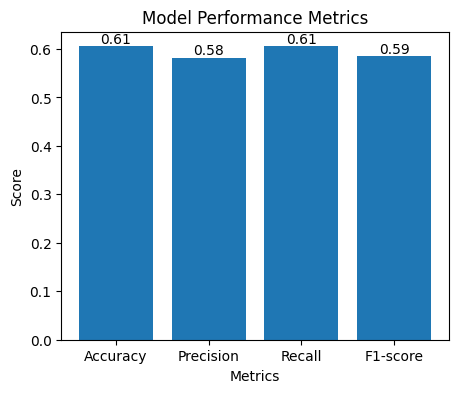

In [14]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

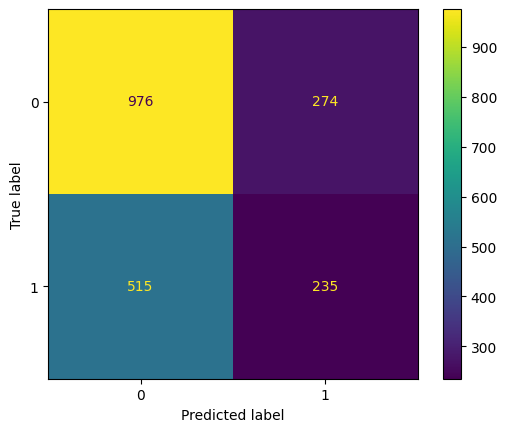

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual_labels, predicted_classes)
ConfusionMatrixDisplay(cm).plot()

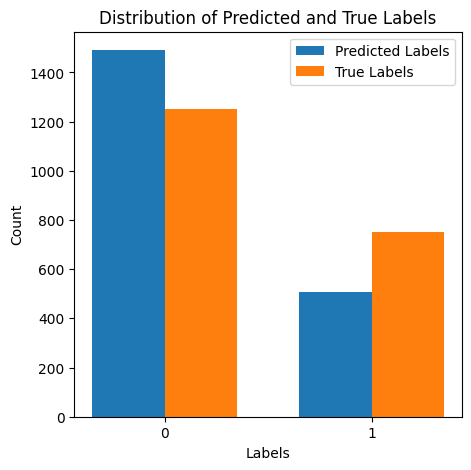

In [16]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()